In [2]:
import csv
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from verstack.stratified_continuous_split import scsplit # pip install verstack

# Load the training data
train_data = pd.read_csv("data/train.csv")

# Here we split our training data into trainig and testing set. This way we can estimate the evaluation of our model without uploading to Kaggle and avoid overfitting over our evaluation dataset.
# scsplit method is used in order to split our regression data in a stratisfied way and keep a similar distribution of retweet counts between the two sets
X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweet_count'], stratify=train_data['retweet_count'], train_size=0.7, test_size=0.3)

# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(['retweet_count'], axis=1)
X_test = X_test.drop(['retweet_count'], axis=1)

# You can examine the available features using X_train.head()

# We set up an Tfidf Vectorizer that will use the top 100 tokens from the tweets. We also remove stopwords.
# To do that we have to fit our training dataset and then transform both the training and testing dataset. 
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
X_train = vectorizer.fit_transform(X_train['text'])
X_test = vectorizer.transform(X_test['text'])

# Now we can train our model. Here we chose a Gradient Boosting Regressor and we set our loss function 
reg = GradientBoostingRegressor()
# We fit our model using the training data
reg.fit(X_train, y_train)
# And then we predict the values for our testing set
y_pred = reg.predict(X_test)
print("Prediction error:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

###################################
# Once we finalized our features and model we can train it using the whole training set and then produce prediction for the evaluating dataset
###################################
# Load the evaluation data
eval_data = pd.read_csv("data/evaluation.csv")
# Transform our data into tfidf vectors
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
y_train = train_data['retweet_count']
X_train = vectorizer.fit_transform(train_data['text'])
# We fit our model using the training data
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
X_val = vectorizer.transform(eval_data['text'])
# Predict the number of retweets for the evaluation dataset
y_pred = reg.predict(X_val)
# Dump the results into a file that follows the required Kaggle template
with open("gbr_predictions.txt", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "NoRetweets"])
    for index, prediction in enumerate(y_pred):
        writer.writerow([str(eval_data['id'].iloc[index]) , str(int(prediction))])

Prediction error: 264.4361860665567


In [55]:
data = pd.read_csv("data/train.csv")

In [80]:
data

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,hashtags,text
0,0,1588696955143,0,False,68460,1101,1226,NaN,NaN,Smh I give up
1,1,1588464948124,0,False,309,51,202,NaN,NaN,"Most of us are Human Beings, but I think you m..."
2,2,1588634673360,0,False,3241,1675,2325,NaN,NaN,"Old dirty tricks Trump, at it again...like we ..."
3,3,1588433158672,0,False,32327,667,304,NaN,NaN,Seriously..... I worked 86 hours my last check...
4,4,1588582751599,0,False,581,42,127,NaN,NaN,May ALMIGHTY ALLAH have mercy on us all. Only ...
...,...,...,...,...,...,...,...,...,...,...
665772,665772,1588412684317,0,False,65355,1984,1902,NaN,NaN,18 months dawg? Come on man...
665773,665773,1588324521711,1,False,1807,2029,347,StanfordEMED,COVID19,Thank you to all of the nurses in our @Stanfor...
665774,665774,1588353174952,8,False,888,85,257,NaN,NaN,"'Post it' pearls for Palliative, End of Life a..."
665775,665775,1588691378352,0,False,452,38,91,NaN,NaN,His facial expressions are kind of looking for...


In [68]:
data.drop('urls', inplace=True, axis=1)

In [81]:
data.user_friends_count.mean()

2743.131410367135

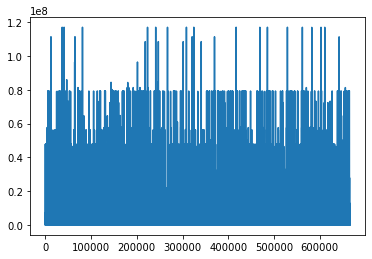

In [78]:
data.user_followers_count.plot()

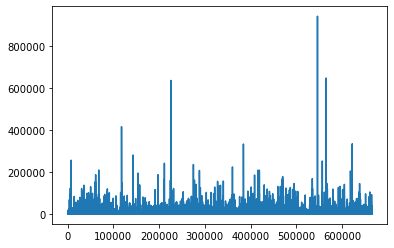

In [76]:
data.retweet_count.plot()